# Generative Question Answering with SQuAD 2.0

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/NLP

/content/drive/MyDrive/NLP


The ability to comprehend and generate human language is one of the most fascinating aspects of Artificial Intelligence. In this realm, Question Answering (QA) stands as a key task, pushing the limits of machine understanding and reasoning. QA systems can be incredibly beneficial in a wide array of applications, from customer service bots to personalized tutoring systems, and even in helping data scientists to extract insights from complex datasets.

However, traditional QA systems are limited in that they typically answer questions based on a predefined set of responses. This is where Generative Question Answering comes into play. Unlike the traditional QA systems, generative QA aims to provide more flexible and contextually appropriate responses, that are not just selected from a predefined list but are generated on-the-fly, based on the understanding of the context and the question.

# Theoretical Background
In this notebook, we'll focus on a generative QA model that utilizes the SQuAD 2.0 dataset and two specific transformer-based models: SentenceTransformer and CrossEncoder.

**SentenceTransformer**: SentenceTransformers is a Python framework for state-of-the-art sentence, text, and image embeddings. The initial purpose of this model was to generate sentence or text embeddings for downstream tasks, such as semantic similarity comparison or clustering. It leverages transformer-based models, like BERT or RoBERTa, and fine-tunes them in a way that the generated embeddings provide semantic representations of the input sentences.

In the context of our notebook, we are using SentenceTransformer to provide an efficient way to compute dense vector representations of our contexts in the SQuAD 2.0 dataset. These embeddings will be used as an index for quick search, allowing us to efficiently retrieve the most semantically relevant contexts given a question.

**CrossEncoder**: CrossEncoder, also part of the SentenceTransformers package, is a model specifically designed for tasks that require understanding the relationship between two texts. It takes a pair of sentences as input and outputs a score that represents the model's assessment of the relevance of these two sentences to each other. Unlike the SentenceTransformer, which independently encodes sentences, the CrossEncoder considers the interaction between pair of sentences, making it well-suited for tasks like sentence-pair classification or ranking.

In our notebook, we use the CrossEncoder to rank the documents retrieved based on the embeddings. Given a question and a context from our quick search, the CrossEncoder outputs a relevance score. These scores are then used to rank the documents, ensuring that the most relevant contexts are considered when generating an answer.


By combining these two models, we are harnessing the strengths of both: the SentenceTransformer for efficient semantic search and the CrossEncoder for precise ranking based on the interaction between the question and the context.

Fine-tuning both these models on the SQuAD 2.0 dataset allows us to benefit from the general language understanding learned by the models on a large corpus, while also specializing them to understand the specific nuances of the SQuAD dataset and the generative QA task at hand.

In summary, this notebook presents a way to leverage the power of fine-tuned embeddings, semantic search, and accurate ranking to build an advanced QA system capable of handling complex, real-world questions. By training and fine-tuning our SentenceTransformer and CrossEncoder models on the SQuAD 2.0 dataset, we are equipping them to answer a wide range of questions with accuracy and finesse, as well as handle questions that are unanswerable.

In [3]:
import tensorflow as tf
import json
import requests
import pandas as pd
import numpy as np

# fix random seed for reproducibility
tf.random.set_seed(7)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# QA Data Preparation

In [4]:
!pip -q install datasets

In [172]:
texts = []
labels = []
answers = []
questions = []
context_dict = {}  # Dictionary to track which sentence belongs to which context

# Extract contexts, questions, and labels (answerable or unanswerable)
for article in squad_dataset['data']:
    for paragraph in article['paragraphs']:
        context = paragraph['context']
        context_sentences = context.split('. ')  # Split the context into individual sentences
        context_dict[len(texts)] = len(texts) + len(context_sentences) - 1  # Map the context to the range of sentence indices
        for sentence in context_sentences:
            for qa in paragraph['qas']:
                question = qa['question']
                questions.append(question)
                if qa['is_impossible']:
                    label = 0
                    answer_text = ""  # For unanswerable questions, we set the answer text to an empty string
                else:
                    label = 1
                    answer_text = qa['answers'][0]['text']  # Extract the plain text of the first answer
                texts.append(sentence)
                labels.append(label)
                answers.append(answer_text)  # Add the answer text to the answers list

# Knowlege Retreival

We have the questions (and the target answers), now we need to prepare our knowledge source and the retrieval system.

In [7]:
!pip -q install transformers==4.22.2
!pip -q install -U sentence-transformers

## Import the Models

Now we can import the two models described in the introduction.

In [8]:
from sentence_transformers import SentenceTransformer, CrossEncoder

semb_model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
xenc_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

## Generate the Embedding using SQUAD 2.0

This code block is responsible for generating the embeddings of the SQuAD 2.0 dataset using the SentenceTransformer model. This process involves converting the text into a tensor format and calculating the embeddings.

In [9]:
import os
import pickle

# Define SentenceTransformer model
semb_model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')

# Define hnswlib index path
embeddings_cache_path = './qa_embeddings_cache.pkl'

# Load cache if available
if os.path.exists(embeddings_cache_path):
    print('Loading embeddings cache')
    with open(embeddings_cache_path, 'rb') as f:
        corpus_embeddings = pickle.load(f)
# Else compute embeddings
else:
    print('Computing embeddings')
    corpus_embeddings = semb_model.encode(texts, convert_to_tensor=True, show_progress_bar=True)
    # Save the index to a file for future loading
    print(f'Saving index to: \'{embeddings_cache_path}\'')
    with open(embeddings_cache_path, 'wb') as f:
        pickle.dump(corpus_embeddings, f)

Loading embeddings cache


## Create HNSWLIB Index for Fast Search

Finally let's index the embeddings.

In [10]:
!pip -q install hnswlib

This block of code deals with the creation, loading, and saving of an [HNSWLIB](https://github.com/nmslib/hnswlib) index, which is used for fast nearest neighbor search.

The first part of the code initializes an empty HNSWLIB index with cosine similarity as the metric space and a dimension size of 384, which corresponds to the dimensionality of the embeddings produced by the SentenceTransformer model.

If the index file does not already exist, the code initializes the index with certain parameters (`max_elements`, `ef_construction`, `M`) that affect its construction and performance. It then adds the embeddings from the `corpus_embeddings` tensor to the index. Each embedding is associated with an identifier from `0` to `len(corpus_embeddings) - 1`. This operation can take some time, given the size of the corpus and the dimensionality of the embeddings.

Once the index is built, it is saved to the specified `index_path` for future use. 

The motivation behind this code block is to create an efficient structure for semantic search. The HNSWLIB index enables fast and accurate nearest neighbor search within the high-dimensional space of the embeddings, making it an essential component of the system's ability to quickly find relevant contexts for a given question. 

In [11]:
import os
import hnswlib

# Create empthy index
index = hnswlib.Index(space='cosine', dim=384)

# Define hnswlib index path
index_path = './qa_hnswlib.index'

# Load index if available
if os.path.exists(index_path):
    print('Loading index...')
    index.load_index(index_path)
# Else index data collection
else:
    # Initialise the index
    print('Start creating HNSWLIB index')
    index.init_index(max_elements=corpus_embeddings.size(0), ef_construction=400, M=64)
    #  Compute the HNSWLIB index (it may take a while)
    index.add_items(corpus_embeddings.cpu(), list(range(len(corpus_embeddings))))
    # Save the index to a file for future loading
    print(f'Saving index to: {index_path}')
    index.save_index(index_path)

Loading index...


## Set Up of T5 model

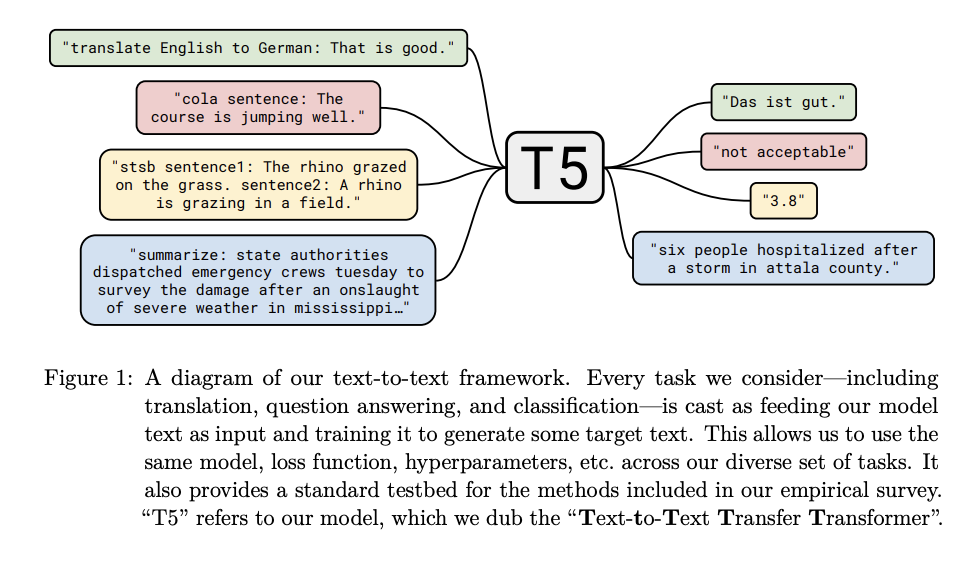

In [12]:
!pip -q install transformers sentencepiece accelerate
!pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


This block of code is responsible for setting up the T5 model, which will be used for generating answers to the questions. The T5 model, short for "Text-to-Text Transfer Transformer", is a transformer-based model that can be used for a variety of NLP tasks. It treats all NLP tasks as text-to-text tasks, hence the name "Text-to-Text".

The T5 model and its corresponding tokenizer are loaded from a pre-trained model checkpoint. The tokenizer is used to convert text into a format that the model can understand, and the model is used to generate the actual answers.

The motivation for using the T5 model is its flexibility and strong performance across a wide range of NLP tasks. By treating every task as a text generation problem, it can be used for tasks like question answering, translation, summarization, and more, without any task-specific architecture modifications. Furthermore, by loading a pre-trained model, we benefit from a model that has been trained on a large amount of data and has already learned a lot of the underlying structure and nuances of the language, which can significantly improve the performance on our specific task.

In [13]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large", device_map="auto", torch_dtype=torch.float16)

# Test Pipeline

Now we can test our pipeline. 
First select randomly a question from the data set

In [178]:
myidx = 500 

question = questions[myidx]
target_answer = answers[myidx]

print(f'Question {myidx}: {question}')

Question 500: Who was the first record label to give the girls a record deal?


## Embed the Question

In [179]:
question_embedding = semb_model.encode(question, convert_to_tensor=True)

## Retrieving the most Semantically similar Contexts to the given Question

This part of the code is responsible for retrieving the most semantically similar contexts to the given question from the indexed embeddings. This is achieved by using the HNSWLIB index for a nearest neighbors search.

First, the code performs a k-nearest neighbors search on the HNSWLIB index, using the embedding of the question as the query. The number of neighbors retrieved is specified by `k=64`. The function `knn_query` returns the ids and distances of the nearest neighbors in the index. The distances are then converted to scores by subtracting them from 1, as the distances are cosine distances and smaller distances correspond to higher similarity.

Next, the code prints the question, followed by the top 5 contexts based on the computed scores. Each context is printed along with its score, which reflects its semantic similarity to the question.

The motivation behind this step is to quickly find the most relevant contexts for the given question. By using the HNSWLIB index, we can efficiently search the high-dimensional space of the embeddings and retrieve the most similar contexts. This step is crucial in narrowing down the potential answers from the vast SQuAD 2.0 dataset to a manageable number of highly relevant contexts.

In [180]:
corpus_ids, distances = index.knn_query(question_embedding.cpu(), k=64)
scores = 1 - distances

print("Cosine similarity model search results")
print(f"Query: \"{question}\"")
print("---------------------------------------")

visited_contexts = set()

for idx, score in zip(corpus_ids[0], scores[0]):
    context_idx = next(context_idx for context_idx, end_idx in context_dict.items() if idx <= end_idx)
    if context_idx in visited_contexts:
        continue

    visited_contexts.add(context_idx)

    sentence_idx = idx - context_idx

    print(f"Score: {score:.4f}")
    #print(f"Context: \"{texts[context_idx]}\"")
    print(f"Sentence: \"{texts[idx]}\"")
    print()


Cosine similarity model search results
Query: "Who was the first record label to give the girls a record deal?"
---------------------------------------
Score: 0.6220
Sentence: "The girls auditioned before record labels and were finally signed to Elektra Records, moving to Atlanta Records briefly to work on their first recording, only to be cut by the company"

Score: 0.5278
Sentence: "In 1958, Columbia founded another label, Date Records, which initially issued rockabilly music."

Score: 0.5133
Sentence: "All the runners-up of the first ten seasons, as well as some of other finalists, have also received record deals with major labels"

Score: 0.5067
Sentence: "However, many independent Chicago-based record labels were making appearances on the Dance Chart with their releases"

Score: 0.4966
Sentence: "The group released their first compilation album Number 1's on October 25, 2005, in the US and accepted a star on the Hollywood Walk of Fame in March 2006."

Score: 0.4954
Sentence: "One 

## Re-rank Retreived Documents

This segment of the code is dedicated to the ranking of the documents based on their relevance to the question at hand. The re-ranking process is accomplished by using the CrossEncoder model.

Initially, the code prepares the inputs for the CrossEncoder model, which are pairs of the question and each of the top retrieved contexts. These inputs are then passed to the CrossEncoder model, which outputs a set of scores. Each score represents the model's assessment of the relevance of the question-context pair.

Next, the code prints the question and then sorts the indices of the scores in descending order. The aim here is to prioritize the contexts that the model deems most relevant to the question.

Finally, the top 5 scores and their corresponding documents are displayed. This step serves to visualize the most relevant contexts as determined by the CrossEncoder model, alongside the scores that reflect their relevance.

The motivation behind this code is to ensure that the most pertinent documents are selected for the subsequent answer generation step. By using the CrossEncoder model, the system is able to take into account the interplay between the question and the context, resulting in a more nuanced ranking process. This helps in achieving higher accuracy and relevance in the generated answers.*

In [208]:
import numpy as np

model_inputs = [(question, texts[idx]) for idx in corpus_ids[0]]
cross_scores = xenc_model.predict(model_inputs)

print("Cross-encoder model re-ranking results")
print(f"Query: \"{question}\"")
print("---------------------------------------")

visited_contexts = set()

last = ''
for idx in np.argsort(-cross_scores):
    context_idx = next(context_idx for context_idx, end_idx in context_dict.items() if idx <= end_idx)
    if context_idx in visited_contexts:
        continue

    visited_contexts.add(context_idx)

    score = cross_scores[idx]
    sentence = texts[corpus_ids[0][idx]]
    context = texts[context_idx]

    if last == sentence:
      continue
    last = sentence
    print(f"Score: {score:.4f}")
    #print(f"Context: \"{context}\"")
    print(f"Sentence: \"{sentence}\"")
    print()


Cross-encoder model re-ranking results
Query: "Who was the first record label to give the girls a record deal?"
---------------------------------------
Score: 6.2857
Sentence: "The girls auditioned before record labels and were finally signed to Elektra Records, moving to Atlanta Records briefly to work on their first recording, only to be cut by the company"



## Use best match to answer (and compare to reference answer)

In [209]:
passage_idx = np.argsort(-cross_scores)[0]
passage = texts[corpus_ids[0][passage_idx]]

input_text = f"Given the following passage, answer the related question.\n\nPassage:\n\n{passage}\n\nQ: {question}?"
input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(device)
print(input_text, "\n")

output_ids = model.generate(input_ids, max_new_tokens=32)
output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
print(f"A (model) : {target_answer}""\n")
print(f"A (target): {target_answer}")

Given the following passage, answer the related question.

Passage:

The girls auditioned before record labels and were finally signed to Elektra Records, moving to Atlanta Records briefly to work on their first recording, only to be cut by the company

Q: Who was the first record label to give the girls a record deal?? 

A (model) : Elektra Records

A (target): Elektra Records


## Make sure we make use of the Context

How do we know if the passage was useful and the model haven't exploited weights memorisation?
Let's try to generate directly the response


In [210]:
input_text = f"Answer the following question.\n\nQ: {question}?"
input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(device)
print(input_text)

output_ids = model.generate(input_ids, max_new_tokens=32)
output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
print(f"\nAnswer without providing the context: {output_text}")

Answer the following question.

Q: Who was the first record label to give the girls a record deal??

Answer without providing the context: rca


# Putting all together

We can finally set up an entire question answering pipeline:
- We have the knowledge
- We have the retreival system
    - We also have the re-ranking system
- We have the asnwering system

Let's define a function that puts everything together: 

In [211]:
def qa_pipeline(
    question_idx,
    similarity_model,
    embeddings_index,
    re_ranking_model,
    generative_model,
    device,
    questions,
    texts,
    answers,
    context_dict,
    tokenizer
):
    question = questions[question_idx]
    if not question.endswith('?'):
        question = question + '?'
    # Embed question
    question_embedding = similarity_model.encode(question, convert_to_tensor=True)
    # Search documents similar to question in index
    corpus_ids, distances = embeddings_index.knn_query(question_embedding.cpu(), k=64)
    # Re-rank results
    xenc_model_inputs = [(question, texts[idx]) for idx in corpus_ids[0]]
    cross_scores = re_ranking_model.predict(xenc_model_inputs)
    # Get best matching passage
    passage_idx = np.argsort(-cross_scores)[0]
    passage = texts[corpus_ids[0][passage_idx]]
    # Encode input
    input_text = f"Given the following passage, answer the related question.\n\nPassage:\n\n{passage}\n\nQ: {question}"
    input_ids = tokenizer.encode(input_text, return_tensors="pt").to(device)
    # Generate output
    output_ids = generative_model.generate(input_ids, max_length=64)
    # Decode output
    output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    # Return result
    return f"Passage: {passage}\n\nQ: {question}\n\nA (model):  {output_text}\n\nA (target): {answers[question_idx]}"


## Examples

Print 20 random examples

In [218]:
import random

for _ in range(2):
    random_idx = random.randint(0, len(questions) - 1)
    if labels[random_idx] != 1:
        continue

    result = qa_pipeline(
        random_idx,
        similarity_model=semb_model,
        embeddings_index=index,
        re_ranking_model=xenc_model,
        generative_model=model,
        device=device,
        questions=questions,
        texts=texts,
        answers=answers,
        context_dict=context_dict,
        tokenizer=tokenizer
    )

    print(result)
    print("======================================================================================\n")


Passage: Ford-class carrier (estimated service 2016) compared to the smaller $2 billion 45,000 ton America-class amphibious assault ships able to deploy squadrons of F-35B of which one is already active, another is under construction and nine more are planned.

Q: How much does the America-class amphibious assault ship weigh?

A (model):  45,000 ton

A (target): 45,000 ton

Passage: The aircraft should be off of the airport and in the air in 90 minutes

Q: How long should it take for an aircraft to be off the airport and in the air?

A (model):  90 minutes

A (target): 90 minutes



# Evaluation

The primary metrics used for evaluation in the SQuAD 2.0 dataset are Exact Match (EM) and F1 score: 

1.  **Exact Match (EM):** This is a binary score that indicates whether the predicted answer exactly matches the ground truth answer.
2.   **F1 score:** This is the harmonic mean of precision and recall, which provides a balanced measure of the model's performance even when the class distribution is unbalanced.

In [219]:
import string
import re
import collections

def normalize_answer(s):
    """Lower text and remove punctuation, articles, and extra whitespace."""
    def remove_articles(text):
        regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)
        return re.sub(regex, ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

def get_tokens(s):
    if not s: return []
    return normalize_answer(s).split()

def compute_exact(a_gold, a_pred):
    return int(normalize_answer(a_gold) == normalize_answer(a_pred))

def compute_f1(a_gold, a_pred):
    gold_toks = get_tokens(a_gold)
    pred_toks = get_tokens(a_pred)
    common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
    num_same = sum(common.values())
    if len(gold_toks) == 0 or len(pred_toks) == 0:
        return int(gold_toks == pred_toks)
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

def evaluate(prediction, ground_truth):
    exact_score = compute_exact(ground_truth, prediction)
    f1_score = compute_f1(ground_truth, prediction)
    return {"exact": exact_score, "f1": f1_score}


In [220]:
def qa_pipeline_raw(
    question_idx,
    similarity_model=semb_model,
        embeddings_index=index,
        re_ranking_model=xenc_model,
        generative_model=model,
        device=device,
        questions=questions,
        texts=texts,
        answers=answers,
        context_dict=context_dict,
        tokenizer=tokenizer
):
    question = questions[question_idx]
    if not question.endswith('?'):
        question = question + '?'
    # Embed question
    question_embedding = similarity_model.encode(question, convert_to_tensor=True)
    # Search documents similar to question in index
    corpus_ids, distances = embeddings_index.knn_query(question_embedding.cpu(), k=64)
    # Re-rank results
    xenc_model_inputs = [(question, texts[idx]) for idx in corpus_ids[0]]
    cross_scores = re_ranking_model.predict(xenc_model_inputs)
    # Get best matching passage
    passage_idx = np.argsort(-cross_scores)[0]
    passage = texts[corpus_ids[0][passage_idx]]
    # Encode input
    input_text = f"Given the following passage, answer the related question.\n\nPassage:\n\n{passage}\n\nQ: {question}"
    input_ids = tokenizer.encode(input_text, return_tensors="pt").to(device)
    # Generate output
    output_ids = generative_model.generate(input_ids, max_length=64)
    # Decode output
    output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    

    # Return result
    return passage, question, output_text, answers[question_idx]

Some examples:

In [267]:
passage, question, output_text, answer = qa_pipeline_raw(4)
print(question)
print(passage)
print(output_text)
print(answer)

In which decade did Beyonce become famous?
Achieving the accomplishment of becoming her longest-running Hot 100 single in her career, "Halo"'s success in the US helped Beyoncé attain more top-ten singles on the list than any other woman during the 2000s
2000s
late 1990s


In [266]:
passage, question, output_text, answer = qa_pipeline_raw(3)
print(question)
print(passage)
print(output_text)
print(answer)

In what city and state did Beyonce  grow up? ?
Beyoncé Giselle Knowles was born in Houston, Texas, to Celestine Ann "Tina" Knowles (née Beyincé), a hairdresser and salon owner, and Mathew Knowles, a Xerox sales manager
Houston, Texas
Houston, Texas


In [268]:
passage, question, output_text, answer = qa_pipeline_raw(502)
print(question)
print(passage)
print(output_text)
print(answer)

In what year did Beyonce's father quit his job to manage her group?
In 1995 Beyoncé's father resigned from his job to manage the group
1995
1995


## Single Example

In [269]:
random_idx = 502
passage, question, output_text, answer = qa_pipeline_raw(random_idx)

result = evaluate(output_text, answer)
print(f"Exact match: {result['exact']}, F1 score: {result['f1']}\n")
print(passage)
print(question)
print(output_text)
print(answer)

Exact match: 1, F1 score: 1.0

In 1995 Beyoncé's father resigned from his job to manage the group
In what year did Beyonce's father quit his job to manage her group?
1995
1995


## All Samples

In [270]:
total_f1 = 0.0
total_exact_match = 0.0
num_samples = len(questions)

for myidx in range(0, 10):
    if labels[myidx] == 0:
      continue
    
    passage, question, output_text, answer = qa_pipeline_raw(myidx)
    result = evaluate(output_text, answer)
    
    exact_match = result['exact']
    f1 = result['f1']
    
    print(f"Passage: {passage}\n\nQ: {question}\n\nA (model):  {output_text}\n\nA (target): {answer}")
    print(f"\nF1: {f1}")
    print("=========\n")

    total_exact_match += exact_match
    total_f1 += f1
    
avg_exact_match = total_exact_match / num_samples
avg_f1 = total_f1 / num_samples

print(f"Final F1: {avg_f1}")

Passage: In March 2009, Beyoncé embarked on the I Am..

Q: When did Beyonce start becoming popular?

A (model):  March 2009

A (target): in the late 1990s

F1: 0

Passage: In fall of 1990, Beyoncé enrolled in Parker Elementary School, a music magnet school in Houston, where she would perform with the school's choir

Q: What areas did Beyonce compete in when she was growing up?

A (model):  choir

A (target): singing and dancing

F1: 0

Passage: Following the disbandment of Destiny's Child in June 2005, she released her second solo album, B'Day (2006), which contained hits "Déjà Vu", "Irreplaceable", and "Beautiful Liar"

Q: When did Beyonce leave Destiny's Child and become a solo singer?

A (model):  June 2005

A (target): 2003

F1: 0

Passage: Beyoncé Giselle Knowles was born in Houston, Texas, to Celestine Ann "Tina" Knowles (née Beyincé), a hairdresser and salon owner, and Mathew Knowles, a Xerox sales manager

Q: In what city and state did Beyonce  grow up? ?

A (model):  Houston, 

## Visualize Embeddings

### Plot Embeddings using PCA

Plotting the embeddings of questions, contexts, proposed answers, and actual answers can provide several valuable insights:

1. **Understanding model behavior**: Visualizing embeddings can provide insights into how the model is interpreting and representing these different types of inputs. For instance, if questions and their corresponding answers (whether proposed or actual) tend to be close together in the embedding space, it suggests the model is effectively capturing the semantic relationship between them.

2. **Model diagnostic**: If certain types of inputs consistently result in poor performance (e.g., they are far from their correct counterparts in the embedding space), this could indicate areas where additional training data or model tuning is needed. 

3. **Exploration of semantic relationships**: The embedding space can also be used to explore semantic relationships within your data. For example, are certain questions or contexts consistently more similar to each other? Do certain answers cluster together? 

4. **Quality of the embedding model**: If a model is generating good quality embeddings, semantically similar sentences should be close to each other in the embedding space. So, questions should be close to their correct answers, and far from incorrect ones.

Remember that these visualizations are a projection of high-dimensional space into 2D or 3D, so they can't capture all the nuances of the embeddings. But they can provide a useful high-level view of what's happening in your model.

In [244]:
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.colors as mcolors
plt.style.use('ggplot')

def plot_embeddings(texts, labels):
    # Generate embeddings for each text
    My_embeddings = semb_model.encode(texts, convert_to_tensor=True, show_progress_bar=True)
    # Move embeddings to CPU
    My_embeddings = My_embeddings.cpu()

    # Use PCA to reduce the dimensionality to 2 dimensions
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(My_embeddings)

    # Plot the embeddings
    plt.figure(figsize=(10, 10))
    for i, label in enumerate(labels):
        x, y = embeddings_2d[i]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                     ha='right', va='bottom', fontsize=10)
    plt.title("Visualization of Sentence Embedding using PCA")
    plt.show()

In [284]:
# Get data
collected_questions = []
collected_answers = []
collected_targets = []
collected_contexts = []
collected_labels = []

count = 0
myidx = 0
while count < 2: 
  if labels[myidx] == 0:
      continue
  my_passage, my_question, my_output_text, my_answer = qa_pipeline_raw(myidx)
  result = evaluate(my_output_text, my_answer)
  myidx += 1
  if True:# result['f1'] > 0.4:
    count +=1
    collected_questions.append(my_question)
    print("Question Index: " + str(myidx))
    print("Question: " + my_question)
    collected_answers.append(my_output_text)
    print("Model Answer: " + my_output_text)
    collected_targets.append(my_answer)
    print("Target Answer: " + my_answer)
    collected_contexts.append(my_passage)
    print("Identified passage: " + my_passage)
    collected_labels.append(myidx)
    print("\n")
# Combine all texts
mytexts = []
mylabels = []
for i in range(len(collected_labels)):  # Assuming you have 3 samples
    mytexts.extend([collected_questions[i], collected_answers[i], collected_targets[i], collected_contexts[i]])
    mylabels.extend([
        f"Q {i+1}",
        f"A(M) {i+1}",
        f"A(T) {i+1}",
        f"C {i+1}",
    ])

Question Index: 1
Question: When did Beyonce start becoming popular?
Model Answer: March 2009
Target Answer: in the late 1990s
Identified passage: In March 2009, Beyoncé embarked on the I Am..


Question Index: 2
Question: What areas did Beyonce compete in when she was growing up?
Model Answer: choir
Target Answer: singing and dancing
Identified passage: In fall of 1990, Beyoncé enrolled in Parker Elementary School, a music magnet school in Houston, where she would perform with the school's choir




Batches:   0%|          | 0/1 [00:00<?, ?it/s]

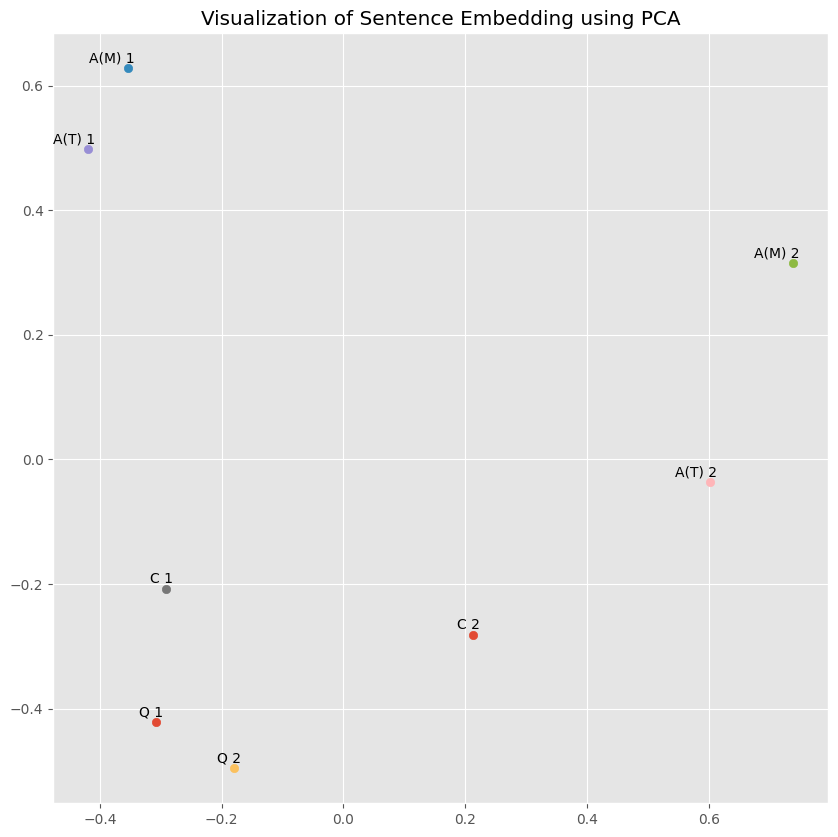

In [281]:
# Plot the embeddings
plot_embeddings(mytexts, mylabels)

### Plot Embeddings unsing Heatmap

In [285]:
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

def plot_heatmap(texts, labels):
    # Generate embeddings for each text
    My_embeddings = semb_model.encode(texts, convert_to_tensor=True, show_progress_bar=True)
    # Move embeddings to CPU
    My_embeddings = My_embeddings.cpu().numpy()

    # Compute cosine similarity
    cosine_sim_matrix = cosine_similarity(My_embeddings)

    # Plot the heatmap
    plt.figure(figsize=(10, 10))
    sns.heatmap(cosine_sim_matrix, xticklabels=labels, yticklabels=labels, annot=True, cmap='viridis')
    plt.show()

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

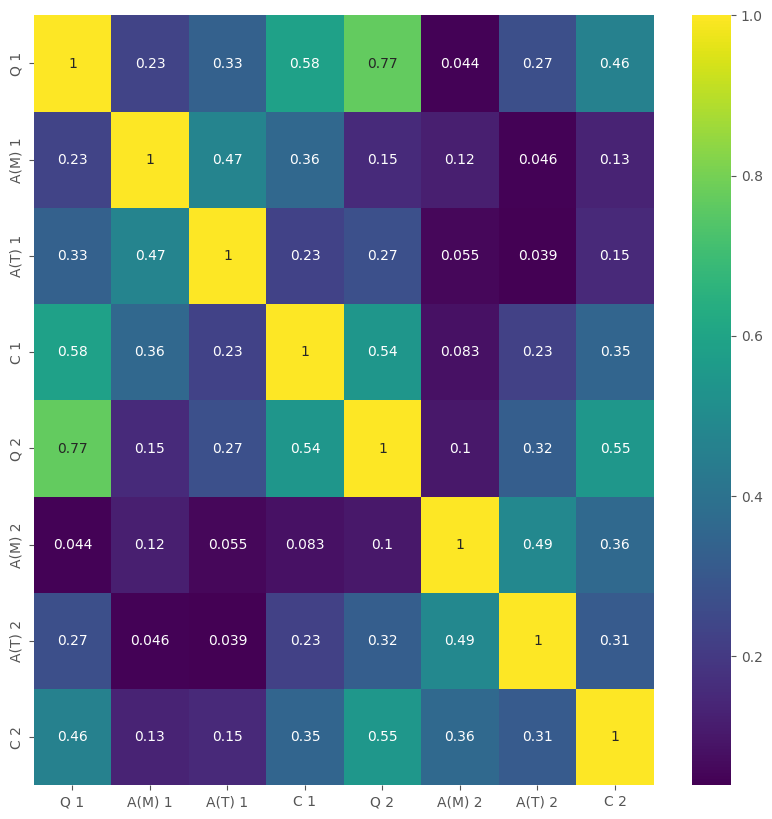

In [286]:
plot_heatmap(mytexts, mylabels)

As one can observe, the context of the second question is correlated with the answers of the ground truth and model. Controversely one can clearly see how there is almost no correlation between the sets of conxtext 1 and 2.